## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn 

%matplotlib inline
plt.style.use('ggplot')

from image_clean import *
from sklearn.model_selection import train_test_split

# Neural Network Imports
from keras.models import Sequential
from keras.layers import Dense , Activation , Dropout ,Flatten
from keras.layers.convolutional import Conv2D, Conv1D
from keras.layers.convolutional import MaxPooling2D
from keras.metrics import categorical_accuracy
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
from keras.optimizers import *
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


## Import Image Dataset

In [7]:
df = pd.read_csv('../data/fer2013.csv')

In [17]:
df

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


In [2]:
df = pd.read_csv('../data/fer2013.csv')

In [3]:
df.Usage.value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

In [8]:
training_df = df[df['Usage'] == 'Training']
validation_df = df[df['Usage'] == 'PublicTest']
test_df = df[df.Usage == 'PrivateTest']

In [9]:
Emotions = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

In [10]:
training_df["emotion"].value_counts(sort=False)

0    3995
1     436
2    4097
3    7215
4    4830
5    3171
6    4965
Name: emotion, dtype: int64

In [7]:
def fer2013_show_instance(index):
    """Shows the image and the emotion label of the index's instance."""
    image = np.reshape(training_df.at[index, "pixels"].split(" "), (48, 48)).astype("float")
    image -= np.mean(image)
    image /= np.std(image)
    print(Emotions[training_df.at[index, "emotion"]])
    plt.imshow(image, cmap="gray")

Happy


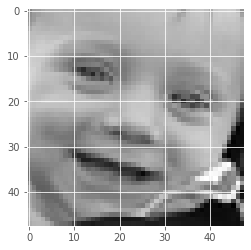

In [8]:
fer2013_show_instance(np.random.randint(0,len(training_df)))

In [2]:
def fer2013_to_X(df):
    """Transforms the (blank separated) pixel strings in the DataFrame to an 3-dimensional array 
    (1st dim: instances, 2nd and 3rd dims represent 2D image)."""
    
    X = []
    pixels_list = df["pixels"].values
    
    for pixels in pixels_list:
        single_image = np.reshape(pixels.split(" "), (48, 48)).astype("float")
        X.append(single_image)
        
    # Convert list to 4D array:
    X = np.expand_dims(np.array(X), -1)
    
    # Normalize image data:
    X -= np.mean(X, axis=0)
    X /= np.std(X, axis=0)
    
    return X

In [9]:
X_val = fer2013_to_X(validation_df)

In [10]:
# Get labels (one-hot encoded)
y_val = pd.get_dummies(validation_df['emotion']).values
y_val.shape

(3589, 7)

In [14]:
X = fer2013_to_X(training_df)

In [12]:
X_val

Predicted and true label values saved
Accuracy on test set :61.79994427417108%


NameError: name 'X_val' is not defined

In [16]:
# Get labels (one-hot encoded)
y = pd.get_dummies(training_df['emotion']).values
y.shape

(28709, 7)

In [19]:

model = Sequential()
input_shape = (48,48,1)
model.add(Conv2D(64, (3, 3), input_shape=input_shape,activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(7))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=Adam(lr=0.001))

In [23]:
earlystop = EarlyStopping(monitor='val_loss',
                          patience=20,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=20,
                              verbose=1,
                              min_delta=0.0001)

In [25]:
h=model.fit(x=X,     
            y=y, 
            batch_size=64, 
            epochs=100, 
            verbose=1, 
            validation_data=(X_val,y_val),
            shuffle=True,
            callbacks=[earlystop, reduce_lr]
            )

Train on 28709 samples, validate on 3589 samples
Epoch 1/100
28709/28709 [==============================] - 29s 1ms/step - loss: 0.1143 - acc: 0.9642 - val_loss: 2.2312 - val_acc: 0.6085
Epoch 2/100
28709/28709 [==============================] - 29s 1ms/step - loss: 0.1023 - acc: 0.9675 - val_loss: 2.3433 - val_acc: 0.6124
Epoch 3/100
28709/28709 [==============================] - 29s 1ms/step - loss: 0.0899 - acc: 0.9719 - val_loss: 2.3674 - val_acc: 0.6275
Epoch 4/100
28709/28709 [==============================] - 29s 1ms/step - loss: 0.0925 - acc: 0.9726 - val_loss: 2.3584 - val_acc: 0.6130
Epoch 5/100
28709/28709 [==============================] - 29s 1ms/step - loss: 0.0878 - acc: 0.9737 - val_loss: 2.2990 - val_acc: 0.6094
Epoch 6/100
28709/28709 [==============================] - 29s 1ms/step - loss: 0.0857 - acc: 0.9736 - val_loss: 2.2688 - val_acc: 0.6160
Epoch 7/100
28709/28709 [==============================] - 29s 1ms/step - loss: 0.0859 - acc: 0.9722 - val_loss: 2.3823 - v

In [26]:
scores = model.evaluate(X_val, y_val)
print('%s: %.2f%%'% (model.metrics_names[1], scores[1]*100))

3589/3589 [==============================] - 2s 477us/step
acc: 61.55%


In [27]:
model.save('fer2013.h5')
model.save_weights('fer2013_weights.h5')

In [18]:
def get_emotion(ohv):
    if ohv.shape[0] == 1:
        indx = ohv[0]
    else:
        indx = np.argmax(ohv)
        
    if indx == 0:
        return 'angry'
    elif indx == 1:
        return 'disgust'
    elif indx == 2:
        return 'fear'
    elif indx == 3:
        return 'happy'
    elif indx == 4:
        return 'sad'
    elif indx == 5:
        return 'surprise'
    elif indx == 6:
        return 'neutral'

[0]


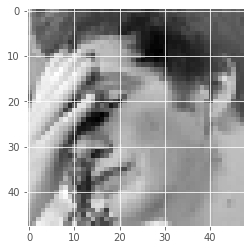

> testing image index: 2996
> true emotion: sad
> predicted emotion: angry


In [27]:
img_indx = np.uint32(np.random.rand()*(validation_df.shape[0] - 1))
sample = X_val[img_indx, :]
sample = sample.reshape(48, 48)

pred_cls = model.predict_classes(sample.reshape(1, 48, 48, 1))
print(pred_cls)
plt.imshow(sample, cmap='gray')
plt.show()
print('> testing image index: %d\n> true emotion: %s\n> predicted emotion: %s' % (img_indx, get_emotion(y_val[img_indx, :]), get_emotion(pred_cls)))